In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from seqprop.visualization import *
from seqprop.generator import *
from seqprop.predictor import *
from seqprop.optimizer import *

from definitions.optimus5_retrained_genetic_algo import load_saved_predictor

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

import warnings
warnings.simplefilter("ignore")

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:

## Download Optimus 5' UTR model 
#!wget https://github.com/pjsample/human_5utr_modeling/raw/master/modeling/saved_models/main_MRL_model.hdf5
#!wget https://github.com/pjsample/human_5utr_modeling/raw/master/modeling/saved_models/retrained_evolution_model.hdf5
#!wget https://github.com/pjsample/human_5utr_modeling/raw/master/modeling/saved_models/evolution_model.hdf5


In [3]:

def load_data(vae_encoder) :
    
    #Load cached dataframe

    n_train = 5000
    n_test = 1000

    n_seqs = n_train + n_test

    df = pd.read_csv('optimus5_seqs_strong_high_readcount.csv', sep='\t')
    seqs = df['utr'].values.tolist()[:n_seqs]

    print("len(seqs) = " + str(len(seqs)) + " (loaded)")

    x_test = np.concatenate([np.expand_dims(np.expand_dims(vae_encoder(seq), axis=0), axis=0) for seq in seqs[n_train:]], axis=0)

    print(x_test.shape)
    
    return x_test


In [4]:
#Specfiy problem-specific parameters

vae_path = "vae/saved_models/vae_optimus5_strong_len_54_latent_100_epochs_50_kl_factor_15_annealed_high_rc"

#VAE model path
saved_vae_encoder_model_path = vae_path + "_encoder.h5"
saved_vae_decoder_model_path = vae_path + "_decoder.h5"

#Padding for the VAE
vae_upstream_padding = ''
vae_downstream_padding = ''

#VAE sequence template
vae_sequence_template = 'N' * 54

#VAE latent dim
vae_latent_dim = 100

#Subtring indices for VAE
vae_pwm_start = 0
vae_pwm_end = 54

#VAE parameter collection
vae_params = [
    saved_vae_encoder_model_path,
    saved_vae_decoder_model_path,
    vae_upstream_padding,
    vae_downstream_padding,
    vae_latent_dim,
    vae_pwm_start,
    vae_pwm_end
]

acgt_encoder = IdentityEncoder(54, {'A':0, 'C':1, 'G':2, 'T':3})

#Load VAE models
vae_encoder_model = load_model(saved_vae_encoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':lambda y_true,y_pred:y_pred})
vae_decoder_model = load_model(saved_vae_decoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':lambda y_true,y_pred:y_pred})

#Load data set
x_test = load_data(acgt_encoder)


len(seqs) = 6000 (loaded)
(1000, 1, 54, 4)


In [5]:
from scipy.stats import norm

def get_z_sample_numpy(z_mean, z_log_var, n_samples=1) :
    
    n = z_mean.shape[0]
    m = z_mean.shape[2]
    
    epsilon = np.random.normal(loc=0., scale=1., size=(n, n_samples, m))
    
    return z_mean + np.exp(0.5 * z_log_var) * epsilon

#Evaluate VAE Likelihood (ELBO) on supplied data
def evaluate_elbo(vae_encoder_model, vae_decoder_model, sequence_one_hots, pwm_start=0, pwm_end=-1, n_samples=1) :
    _epsilon = 10**-6
    
    if pwm_end == -1 :
        pwm_end = sequence_one_hots.shape[2]
    
    #Get sequence VAE encodings
    z_mean, z_log_var, _ = vae_encoder_model.predict(x=sequence_one_hots, batch_size=32, verbose=False)

    z_mean = np.tile(np.expand_dims(z_mean, axis=1), (1, n_samples, 1))
    z_log_var = np.tile(np.expand_dims(z_log_var, axis=1), (1, n_samples, 1))
    z = get_z_sample_numpy(z_mean, z_log_var, n_samples=n_samples)
    
    #Get re-decoded sequence PWMs
    s_dummy = np.zeros((sequence_one_hots.shape[0], 1))
    
    decoded_pwms = np.zeros((sequence_one_hots.shape[0], n_samples) + sequence_one_hots.shape[1:])

    for sample_ix in range(n_samples) :
        _, decoded_pwm, _ = vae_decoder_model.predict(x=[s_dummy, z[:, sample_ix, :]], batch_size=32, verbose=False)
        decoded_pwms[:, sample_ix, :, :, :] = decoded_pwm

    sequence_one_hots_expanded = np.tile(np.expand_dims(sequence_one_hots, 1), (1, n_samples, 1, 1, 1))
    
    #Calculate reconstruction log prob
    log_p_x_given_z = np.sum(np.sum(sequence_one_hots_expanded[:, :, :, pwm_start:pwm_end, :] * np.log(np.clip(decoded_pwms[:, :, :, pwm_start:pwm_end, :], _epsilon, 1. - _epsilon)) / np.log(10.), axis=(2, 4)), axis=2)

    #Calculate standard normal and importance log probs
    log_p_std_normal = np.sum(norm.logpdf(z, 0., 1.) / np.log(10.), axis=-1)
    log_p_importance = np.sum(norm.logpdf(z, z_mean, np.sqrt(np.exp(z_log_var))) / np.log(10.), axis=-1)

    #Calculate per-sample ELBO
    log_p_vae = log_p_x_given_z + log_p_std_normal - log_p_importance
    log_p_vae_div_n = log_p_vae - np.log(n_samples) / np.log(10.)

    #Calculate mean ELBO across samples (log-sum-exp trick)
    max_log_p_vae = np.max(log_p_vae_div_n, axis=-1)
    
    log_mean_p_vae = max_log_p_vae + np.log(np.sum(10**(log_p_vae_div_n - np.expand_dims(max_log_p_vae, axis=-1)), axis=-1)) / np.log(10.)
    mean_log_p_vae = np.mean(log_mean_p_vae)
    
    return log_mean_p_vae, mean_log_p_vae, log_p_vae


In [6]:
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/beyond-binary-ternary-and-one-hot-neurons.html
#See Github https://github.com/spitis/

def st_sampled_softmax(logits):
    with ops.name_scope("STSampledSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.squeeze(tf.multinomial(logits, 1), 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

def st_hardmax_softmax(logits):
    with ops.name_scope("STHardmaxSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.argmax(nt_probs, 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)


mean log(likelihood) = -30.224556442149588


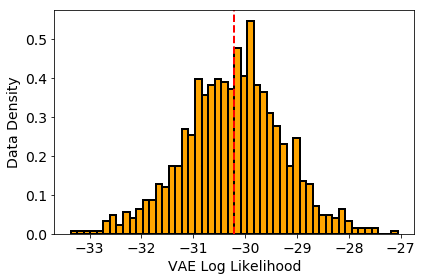

In [9]:
#Evaluate ELBO distribution on test set

#Compute multi-sample ELBO on test set
log_mean_p_vae_test, mean_log_p_vae_test, log_p_vae_test = evaluate_elbo(vae_encoder_model, vae_decoder_model, x_test, n_samples=32)

print("mean log(likelihood) = " + str(mean_log_p_vae_test))

#Log Likelihood Plot
plot_min_val = None
plot_max_val = None

f = plt.figure(figsize=(6, 4))

log_p_vae_test_hist, log_p_vae_test_edges = np.histogram(log_mean_p_vae_test, bins=50, density=True)
bin_width_test = log_p_vae_test_edges[1] - log_p_vae_test_edges[0]

plt.bar(log_p_vae_test_edges[1:] - bin_width_test/2., log_p_vae_test_hist, width=bin_width_test, linewidth=2, edgecolor='black', color='orange')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if plot_min_val is not None and plot_max_val is not None :
    plt.xlim(plot_min_val, plot_max_val)

plt.xlabel("VAE Log Likelihood", fontsize=14)
plt.ylabel("Data Density", fontsize=14)

plt.axvline(x=mean_log_p_vae_test, linewidth=2, color='red', linestyle="--")

plt.tight_layout()
plt.show()


In [7]:
#Helper dummy function for loading keras models
def min_pred(y_true, y_pred) :
        return y_pred

#Keras function to calculate normal distribution log pdf
def normal_log_prob(x, loc=0., scale=1.) :
    return _normal_log_unnormalized_prob(x, loc, scale) - _normal_log_normalization(scale)

def _normal_log_unnormalized_prob(x, loc, scale):
    return -0.5 * K.square((x - loc) / scale)

def _normal_log_normalization(scale):
    return 0.5 * K.log(2. * K.constant(np.pi)) + K.log(scale)

#Keras function to sample latent vectors
def get_z_sample(z_inputs) :
    
    z_mean, z_log_var = z_inputs
    
    batch_size = K.shape(z_mean)[0]
    latent_dim = K.int_shape(z_mean)[1]
    
    epsilon = K.random_normal(shape=(batch_size, latent_dim))
    
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

#Keras function to sample (multiple) latent vectors
def get_z_samples(z_inputs, n_z_samples=1) :
    
    z_mean, z_log_var = z_inputs
    
    batch_size = K.shape(z_mean)[0]
    n_samples = K.shape(z_mean)[1]
    latent_dim = K.int_shape(z_mean)[3]
    
    epsilon = K.random_normal(shape=(batch_size, n_samples, n_z_samples, latent_dim))
    
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

#Code for constructing a (differentiable) VAE ELBO estimator in Keras
def build_vae(generator, encoder_model_path, decoder_model_path, batch_size=1, seq_length=205, n_samples=1, n_z_samples=1, vae_latent_dim=100, vae_pwm_start=0, vae_pwm_end=-1, vae_upstream_padding="", vae_downstream_padding="", transform_adversary=False) :
    
    #Connect generated sequence samples from generator to vae
    generated_sequence_pwm = generator.outputs[1]
    generated_sequence_samples = generator.outputs[2]
    
    if vae_pwm_end == -1 :
        vae_pwm_end = seq_length
    
    #Load encoder model
    saved_vae_encoder_model = load_model(encoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred})
    saved_vae_encoder_model.trainable = False
    saved_vae_encoder_model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999))
    
    #Load decoder model
    saved_vae_decoder_model = load_model(decoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred})
    saved_vae_decoder_model.trainable = False
    saved_vae_decoder_model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999))
    
    
    #Construct upstream sequence padding constant for vae
    vae_upstream_mat = None
    if len(vae_upstream_padding) > 0 :
        vae_upstream_mat = np.tile(np.expand_dims(one_hot_encode(vae_upstream_padding, n=1, singleton_axis=-1), axis=1), (batch_size, n_samples, 1, 1, 1))
    
    #Construct downstream sequence padding constant for vae
    vae_downstream_mat = None
    if len(vae_downstream_padding) > 0 :
        vae_downstream_mat = np.tile(np.expand_dims(one_hot_encode(vae_downstream_padding, n=1, singleton_axis=-1), axis=1), (batch_size, n_samples, 1, 1, 1))
    
    
    #Construct vae elbo keras function (lambda layer)
    def _vae_elbo_func(pwm_and_sampled_pwm, vae_upstream_mat=vae_upstream_mat, vae_downstream_mat=vae_downstream_mat, batch_size=batch_size, n_samples=n_samples, n_z_samples=n_z_samples) :
        
        pwm_1, sampled_pwm_1 = pwm_and_sampled_pwm
        
        def _encode_and_sample(saved_vae_encoder_model, pwm, sampled_pwm, vae_pwm_start, vae_pwm_end, vae_upstream_mat, vae_downstream_mat, vae_latent_dim, n_z_samples) :
            vae_pwm = pwm[:, vae_pwm_start:vae_pwm_end, :, :]
            vae_sampled_pwm = sampled_pwm[:, :, vae_pwm_start:vae_pwm_end, :, :]
            if vae_upstream_mat is not None :
                vae_pwm = K.concatenate([K.constant(vae_upstream_mat[:, 0, ...]), vae_pwm], axis=1)
                vae_sampled_pwm = K.concatenate([K.constant(vae_upstream_mat), vae_sampled_pwm], axis=2)
            if vae_downstream_mat is not None :
                vae_pwm = K.concatenate([vae_pwm, K.constant(vae_downstream_mat[:, 0, ...])], axis=1)
                vae_sampled_pwm = K.concatenate([vae_sampled_pwm, K.constant(vae_downstream_mat)], axis=2)

            vae_sampled_pwm_permuted = K.permute_dimensions(vae_sampled_pwm, (0, 1, 4, 2, 3))

            z_param_collection = tf.map_fn(lambda x_in: K.concatenate(saved_vae_encoder_model(x_in), axis=-1)[..., :2*vae_latent_dim], vae_sampled_pwm_permuted, parallel_iterations=16)

            z_mean = K.permute_dimensions(z_param_collection[..., :vae_latent_dim], (0, 1, 2))
            z_log_var = K.permute_dimensions(z_param_collection[..., vae_latent_dim:2*vae_latent_dim], (0, 1, 2))

            z_mean = K.tile(K.expand_dims(z_mean, axis=2), (1, 1, n_z_samples, 1))
            z_log_var = K.tile(K.expand_dims(z_log_var, axis=2), (1, 1, n_z_samples, 1))

            z = get_z_samples([z_mean, z_log_var], n_z_samples=n_z_samples)
            
            return vae_pwm, vae_sampled_pwm, z_mean, z_log_var, z
        
        vae_pwm_1, vae_sampled_pwm_1, z_mean_1, z_log_var_1, z_1 = _encode_and_sample(saved_vae_encoder_model, pwm_1, sampled_pwm_1, vae_pwm_start, vae_pwm_end, vae_upstream_mat, vae_downstream_mat, vae_latent_dim, n_z_samples)
        
        z_1_permuted = K.permute_dimensions(z_1, (0, 2, 1, 3))

        s_1 = K.zeros((batch_size, 1))
        
        decoded_pwm_1 = tf.map_fn(lambda z_in: tf.map_fn(lambda z_in_in: saved_vae_decoder_model([s_1, z_in_in])[1], z_in, parallel_iterations=16), z_1_permuted, parallel_iterations=16)
        decoded_pwm_1 = K.permute_dimensions(decoded_pwm_1, (0, 2, 1, 4, 5, 3))

        vae_pwm_tiled_1 = K.tile(K.expand_dims(vae_pwm_1, axis=1), (1, n_z_samples, 1, 1, 1))
        vae_sampled_pwm_tiled_1 = K.tile(K.expand_dims(vae_sampled_pwm_1, axis=2), (1, 1, n_z_samples, 1, 1, 1))

        return [vae_pwm_tiled_1, vae_sampled_pwm_tiled_1, z_mean_1, z_log_var_1, z_1, decoded_pwm_1]
    
    vae_elbo_layer = Lambda(_vae_elbo_func)
    
    #Call vae elbo estimator on generator sequences
    vae_elbo_outputs = vae_elbo_layer([generated_sequence_pwm, generated_sequence_samples])
    
    return vae_elbo_outputs


In [8]:

def build_loss_model_with_vae(predictor_model, loss_func, extra_loss_tensors=[]) :

    loss_out = Lambda(lambda out: loss_func(out), output_shape = (1,))(predictor_model.outputs + extra_loss_tensors)

    loss_model = Model(predictor_model.inputs, loss_out)

    return 'loss_model', loss_model

def get_punish_atg(pwm_start, pwm_end) :
    
    def punish(pwm) :

        atg_score = K.sum(pwm[..., pwm_start:pwm_end-2, 0, 0] * pwm[..., pwm_start+1:pwm_end-1, 3, 0] * pwm[..., pwm_start+1:pwm_end-1, 2, 0], axis=-1)
        
        return atg_score
    
    return punish

def get_punish_t(pwm_start, pwm_end) :
    
    def punish(pwm) :

        t_score = K.sum(pwm[..., pwm_start:pwm_end, 3, 0], axis=-1)
        
        return t_score
    
    return punish

#Define target isoform loss function
def get_earthmover_loss(pwm_start=0, pwm_end=54, pwm_target_bits=1.8, pwm_entropy_weight=0.0, vae_pwm_start=0, vae_divergence_weight=1., ref_vae_log_p=-10, vae_log_p_margin=1, decoded_pwm_epsilon=10**-6, punish_atg=0.0, punish_t=0.0) :
    
    entropy_mse = get_margin_entropy(pwm_start=pwm_start, pwm_end=pwm_end, min_bits=pwm_target_bits)
    
    punish_atg_func = get_punish_atg(pwm_start=pwm_start, pwm_end=pwm_end)
    punish_t_func = get_punish_t(pwm_start=pwm_start, pwm_end=pwm_end)
    
    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, pred_score, vae_pwm_1, vae_sampled_pwm_1, z_mean_1, z_log_var_1, z_1, decoded_pwm_1 = predictor_outputs

        #Specify costs
        fitness_loss = -1.0 * K.mean(pred_score[..., 0], axis=0)
        
        #Construct VAE sequence inputs
        decoded_pwm_1 = K.clip(decoded_pwm_1, decoded_pwm_epsilon, 1. - decoded_pwm_epsilon)
        
        log_p_x_given_z_1 = K.sum(K.sum(vae_sampled_pwm_1[:, :, :, pwm_start-vae_pwm_start:pwm_end-vae_pwm_start, ...] * K.log(K.stop_gradient(decoded_pwm_1[:, :, :, pwm_start-vae_pwm_start:pwm_end-vae_pwm_start, ...])) / K.log(K.constant(10.)), axis=(-1, -2)), axis=-1)
        
        log_p_std_normal_1 = K.sum(normal_log_prob(z_1, 0., 1.) / K.log(K.constant(10.)), axis=-1)
        log_p_importance_1 = K.sum(normal_log_prob(z_1, z_mean_1, K.sqrt(K.exp(z_log_var_1))) / K.log(K.constant(10.)), axis=-1)
        
        log_p_vae_1 = log_p_x_given_z_1 + log_p_std_normal_1 - log_p_importance_1
        log_p_vae_div_n_1 = log_p_vae_1 - K.log(K.constant(n_z_samples, dtype='float32')) / K.log(K.constant(10.))

        #Calculate mean ELBO across samples (log-sum-exp trick)
        max_log_p_vae_1 = K.max(log_p_vae_div_n_1, axis=-1)

        log_mean_p_vae_1 = max_log_p_vae_1 + K.log(K.sum(10**(log_p_vae_div_n_1 - K.expand_dims(max_log_p_vae_1, axis=-1)), axis=-1)) / K.log(K.constant(10.))
        
        #Specify VAE divergence loss function
        vae_divergence_loss = vae_divergence_weight * K.mean(K.switch(log_mean_p_vae_1 < ref_vae_log_p - vae_log_p_margin, -log_mean_p_vae_1 + (ref_vae_log_p - vae_log_p_margin), K.zeros_like(log_mean_p_vae_1)), axis=0)
        
        seq_loss = 0.0
        seq_loss += punish_atg * K.mean(punish_atg_func(sampled_pwm), axis=0)
        seq_loss += punish_t * K.mean(punish_t_func(sampled_pwm), axis=0)
        
        entropy_loss = pwm_entropy_weight * entropy_mse(pwm)
        
        #Compute total loss
        total_loss = fitness_loss + vae_divergence_loss + seq_loss + entropy_loss

        return K.reshape(K.sum(total_loss, axis=0), (1,))
    
    def val_loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, pred_score = predictor_outputs

        #Specify costs
        fitness_loss = -1.0 * K.mean(pred_score[..., 0], axis=0)
        
        #Compute total loss
        total_loss = fitness_loss

        return K.reshape(K.mean(total_loss, axis=0), (1,))
    
    return loss_func, val_loss_func


def get_nop_transform() :
    
    def _transform_func(pwm) :
        
        return pwm
    
    return _transform_func

class ValidationCallback(Callback):
    def __init__(self, val_name, val_loss_model, val_steps) :
        self.val_name = val_name
        self.val_loss_model = val_loss_model
        self.val_steps = val_steps
        
        self.val_loss_history = []
        
        #Track val loss
        self.val_loss_history.append(self.val_loss_model.predict(x=None, steps=self.val_steps)[0])
    
    def on_batch_end(self, batch, logs={}) :
        #Track val loss
        val_loss_value = self.val_loss_model.predict(x=None, steps=self.val_steps)[0]
        self.val_loss_history.append(val_loss_value)

#Sequence optimization monitor during training
class StoreSequenceMonitor(Callback):
    def __init__(self, seqprop_model, sequence_encoder, run_dir="", run_prefix="", store_every1=5, store_every2=100, swap_iter=100, val_steps=1) :
        self.seqprop_model = seqprop_model
        self.val_steps = val_steps
        self.sequence_encoder = sequence_encoder
        self.run_prefix = run_prefix
        self.run_dir = run_dir
        self.edit_distance_samples = []
        self.store_every1 = store_every1
        self.store_every2 = store_every2
        self.store_every = store_every1
        self.swap_iter = swap_iter
        
        if not os.path.exists(self.run_dir): os.makedirs(self.run_dir)

        seqs = self._sample_sequences()
        #self._store_sequences(seqs, 0)
    
    def _sample_sequences(self) :
        sampled_pwm = self.seqprop_model.predict(x=None, steps=self.val_steps)[2]
        
        seqs = []
        for i in range(sampled_pwm.shape[1]) :
            for j in range(sampled_pwm.shape[0]) :
                seqs.append(self.sequence_encoder.decode(sampled_pwm[j, i, :, :, 0]))
        
        return seqs
    
    def _store_sequences(self, seqs, epoch) :
        #Save sequences to file
        with open(self.run_dir + self.run_prefix + "_epoch_" + str(epoch) + "_" + str(self.val_steps) + "_steps.txt", "w") as f:#"a+") as f:
            for i in range(len(seqs)) :
                f.write(seqs[i] + "\n")
    
    def on_batch_end(self, batch, logs={}) :
        
        if batch > self.swap_iter :
            self.store_every = self.store_every2
        
        if batch % self.store_every == 0 :
            seqs = self._sample_sequences()
            self._store_sequences(seqs, batch)

#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(run_prefix, sequence_templates, loss_funcs, val_loss_funcs, transform_funcs, n_sequences=1, n_samples=1, n_z_samples=1, vae_params=None, n_valid_samples=1, eval_mode='sample', normalize_logits=False, n_epochs=10, steps_per_epoch=100) :
    
    n_objectives = len(sequence_templates)
    
    seqprop_predictors = []
    valid_monitors = []
    train_histories = []
    valid_histories = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        sequence_template = sequence_templates[obj_ix]
        loss_func = loss_funcs[obj_ix]
        val_loss_func = val_loss_funcs[obj_ix]
        transform_func = transform_funcs[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=len(sequence_template), n_sequences=n_sequences, n_samples=n_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=normalize_logits, pwm_transform_func=transform_func, validation_sample_mode='sample')
        #for layer in seqprop_generator.layers :
        #    if 'policy' not in layer.name :
        #        layer.name += "_trainversion"
        _, valid_generator = build_generator(seq_length=len(sequence_template), n_sequences=n_sequences, n_samples=n_valid_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=normalize_logits, pwm_transform_func=None, validation_sample_mode='sample', master_generator=seqprop_generator)
        for layer in valid_generator.layers :
            #if 'policy' not in layer.name :
            layer.name += "_valversion"
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_saved_predictor(model_path, library_context=None), n_sequences=n_sequences, n_samples=n_samples, eval_mode=eval_mode)
        #for layer in seqprop_predictor.layers :
        #    if '_trainversion' not in layer.name and 'policy' not in layer.name :
        #        layer.name += "_trainversion"
        _, valid_predictor = build_predictor(valid_generator, load_saved_predictor(model_path, library_context=None), n_sequences=n_sequences, n_samples=n_valid_samples, eval_mode='sample')
        for layer in valid_predictor.layers :
            if '_valversion' not in layer.name :# and 'policy' not in layer.name :
                layer.name += "_valversion"
        
        #Build VAE model
        vae_tensors = []
        if vae_params is not None :
            encoder_model_path, decoder_model_path, vae_upstream_padding, vae_downstream_padding, vae_latent_dim, vae_pwm_start, vae_pwm_end = vae_params
            vae_tensors = build_vae(seqprop_generator, encoder_model_path, decoder_model_path, batch_size=n_sequences, seq_length=len(sequence_templates[0]), n_samples=n_samples, n_z_samples=n_z_samples, vae_latent_dim=vae_latent_dim, vae_upstream_padding=vae_upstream_padding, vae_downstream_padding=vae_downstream_padding, vae_pwm_start=vae_pwm_start, vae_pwm_end=vae_pwm_end)
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model_with_vae(seqprop_predictor, loss_func, extra_loss_tensors=vae_tensors)
        _, valid_loss_model = build_loss_model(valid_predictor, val_loss_func)
        
        #Specify Optimizer to use
        #opt = keras.optimizers.SGD(lr=0.5)
        #opt = keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0, nesterov=True)
        opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

        def get_logit(p) :
            return np.log(p / (1. - p))
        
        #Specify callback entities
        #measure_func = lambda pred_outs: np.mean(get_logit(np.expand_dims(pred_outs[0], axis=0) if len(pred_outs[0].shape) <= 2 else pred_outs[0]), axis=0)
        measure_func = lambda pred_outs: np.expand_dims(np.mean(np.expand_dims(pred_outs[0][..., [0]], axis=0) if len(pred_outs[0].shape) <= 2 else pred_outs[0][..., [0]], axis=(0, -1)), axis=-1)
        
        #train_monitor = FlexibleSeqPropMonitor(predictor=seqprop_predictor, plot_on_train_end=False, plot_every_epoch=False, track_every_step=True, measure_func=measure_func, measure_name='Activity', plot_pwm_start=500, plot_pwm_end=700, sequence_template=sequence_template, plot_pwm_indices=np.arange(n_sequences).tolist(), figsize=(12, 1.0))
        valid_monitor = FlexibleSeqPropMonitor(predictor=valid_predictor, plot_on_train_end=True, plot_every_epoch=False, track_every_step=True, measure_func=measure_func, measure_name='Activity', plot_pwm_start=0, plot_pwm_end=54, sequence_template=sequence_template, plot_pwm_indices=np.arange(n_sequences).tolist(), figsize=(12, 1.0))
        
        train_history = ValidationCallback('loss', loss_model, 1)
        valid_history = ValidationCallback('val_loss', valid_loss_model, 1)
        
        #Standard sequence decoder
        acgt_encoder = IdentityEncoder(54, {'A':0, 'C':1, 'G':2, 'T':3})
        
        #Build callback for printing intermediate sequences
        store_seq_monitor = StoreSequenceMonitor(valid_generator, acgt_encoder, run_dir="./seqprop_samples/" + run_prefix + "/", run_prefix="intermediate", val_steps=1)
        
        callbacks =[
            #EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            valid_monitor,
            train_history,
            valid_history,
            store_seq_monitor
        ]
        
        #Fit Loss Model
        _ = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        valid_monitor.predictor = None
        train_history.val_loss_model = None
        valid_history.val_loss_model = None
        
        seqprop_predictors.append(seqprop_predictor)
        valid_monitors.append(valid_monitor)
        train_histories.append(train_history)
        valid_histories.append(valid_history)

    return seqprop_predictors, valid_monitors, train_histories, valid_histories


In [9]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '')
model_name = 'evolution_model.hdf5'
model_path = os.path.join(save_dir, model_name)


In [10]:
import random

def set_seed(seed_value) :
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)


Optimizing objective 0...
Epoch 1/1
20001/20001 [==============================] - 4542s 227ms/step - loss: -18.8107


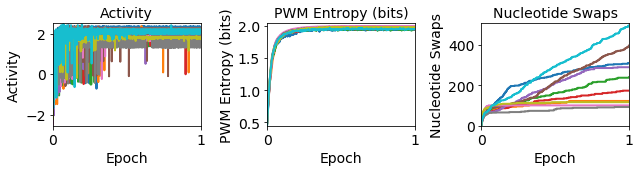

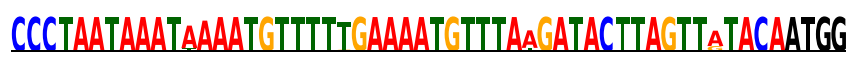

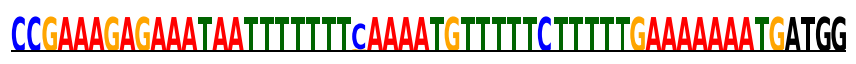

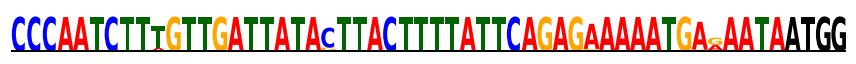

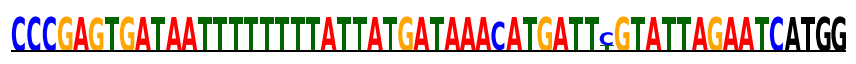

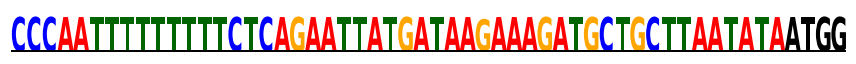

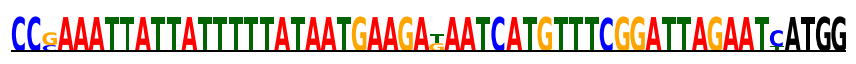

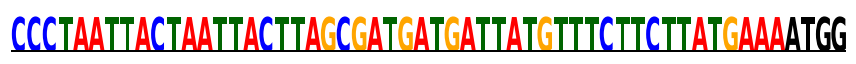

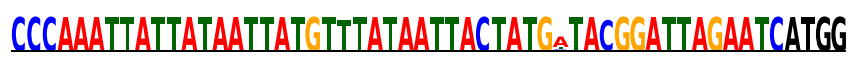

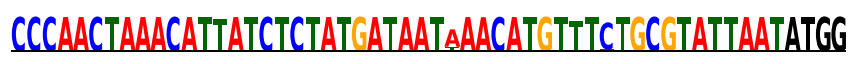

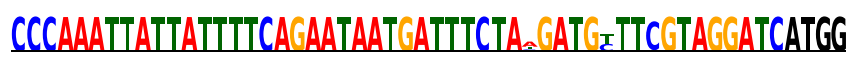

In [11]:

run_prefix = "seqprop_optimus5_non_retrained_20000_updates_elbo"

seq_template = 'N' * 50 + 'ATGG'

rand_seed = 1177#14755

#Run SeqProp Optimization

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of VAE samples
n_z_samples = 32
#Number of epochs per objective to optimize
n_epochs = 1
#Number of steps (grad updates) per epoch
steps_per_epoch = 20000 + 1
#Either 'pwm' or 'sample'
eval_mode = 'sample'
#Normalize sequence logits
normalize_logits = True
#Number of One-hot validation sequences to sample from the PWM
n_valid_samples = 1

sequence_templates = [
    seq_template
]

losses, val_losses = zip(*[
    get_earthmover_loss(
        pwm_start=0,
        pwm_end=54,
        vae_pwm_start=vae_pwm_start,
        vae_divergence_weight=10. * 1./54.,
        ref_vae_log_p=-30.22,
        vae_log_p_margin=0,
        punish_atg=0.0,
        punish_t=0.0
    )
])

transforms = [
    None
]

seqprop_predictors, valid_monitors, train_histories, valid_histories = run_seqprop(run_prefix, sequence_templates, losses, val_losses, transforms, n_sequences, n_samples, n_z_samples, vae_params, n_valid_samples, eval_mode, normalize_logits, n_epochs, steps_per_epoch)

seqprop_predictor, valid_monitor, train_history, valid_history = seqprop_predictors[0], valid_monitors[0], train_histories[0], valid_histories[0]


In [11]:
#Load final sequences

run_prefix = "seqprop_optimus5_non_retrained_20000_updates_elbo"

folder_path = "seqprop_samples/" + run_prefix + "/"
file_path = folder_path + "intermediate_epoch_20000_1_steps.txt"

seq_template = 'N' * 54

seqs = []
with open(file_path, "rt") as f :
    split_on_tab = False
    for l in f.readlines() :
        l_strip = l.strip()
        seq = l_strip
        if split_on_tab :
            seq = l_strip.split("\t")[0]

        if seq_template is not None :
            seq = ''.join([
                seq_template[j] if seq_template[j] != 'N' else seq[j]
                for j in range(len(seq))
            ])

        seqs.append(seq)


In [12]:
#Load VAE models

vae_encoder_model = load_model(saved_vae_encoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':lambda y_true,y_pred:y_pred})
vae_decoder_model = load_model(saved_vae_decoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':lambda y_true,y_pred:y_pred})


In [13]:
#Evaluate ELBOs
n_z_samples = 32

#Evaluate VAE Likelihood on test data
log_mean_p_vae_test, mean_log_p_vae_test, _ = evaluate_elbo(vae_encoder_model, vae_decoder_model, x_test, n_samples=n_z_samples)

#Evaluate VAE Likelihood on generated data
x_gen = np.zeros((len(seqs), 1, 54, 4))
for i in range(len(seqs)) :
    gen_seq = seqs[i]
    
    for j in range(len(gen_seq)) :
        if gen_seq[j] == 'A' :
            x_gen[i, 0, j, 0] = 1.
        elif gen_seq[j] == 'C' :
            x_gen[i, 0, j, 1] = 1.
        elif gen_seq[j] == 'G' :
            x_gen[i, 0, j, 2] = 1.
        elif gen_seq[j] == 'T' :
            x_gen[i, 0, j, 3] = 1.

log_mean_p_vae_new, mean_log_p_vae_new, _ = evaluate_elbo(vae_encoder_model, vae_decoder_model, x_gen, n_samples=n_z_samples)

#Evaluate VAE Likelihood on random data
n = x_test.shape[0]

x_random = np.zeros((n, 1, 54, 4))
for i in range(n) :
    random_seq = ''
    for j in range(len(vae_sequence_template)) :
        if vae_sequence_template[j] == 'N' :
            rand_letter = np.random.choice(['A', 'C', 'G', 'T'], replace=False)
            random_seq += rand_letter
        else :
            random_seq += vae_sequence_template[j]
    
    for j in range(len(random_seq)) :
        if random_seq[j] == 'A' :
            x_random[i, 0, j, 0] = 1.
        elif random_seq[j] == 'C' :
            x_random[i, 0, j, 1] = 1.
        elif random_seq[j] == 'G' :
            x_random[i, 0, j, 2] = 1.
        elif random_seq[j] == 'T' :
            x_random[i, 0, j, 3] = 1.

log_mean_p_vae_random, mean_log_p_vae_random, _ = evaluate_elbo(vae_encoder_model, vae_decoder_model, x_random, n_samples=n_z_samples)


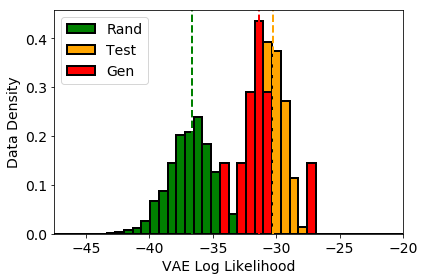

In [14]:
#Compare VAE Log Likelihoods (ELBO), With random background

def plot_joint_histo(measurements, labels, colors, x_label, y_label, n_bins=50, figsize=(6, 4), save_fig=False, fig_name="default_1", fig_dpi=150, min_val=None, max_val=None, max_y_val=None) :
    
    min_hist_val = np.min(measurements[0])
    max_hist_val = np.max(measurements[0])
    for i in range(1, len(measurements)) :
        min_hist_val = min(min_hist_val, np.min(measurements[i]))
        max_hist_val = max(max_hist_val, np.max(measurements[i]))
    
    if min_val is not None :
        min_hist_val = min_val
    if max_val is not None :
        max_hist_val = max_val

    hists = []
    bin_edges = []
    means = []
    for i in range(len(measurements)) :
        hist, b_edges = np.histogram(measurements[i], range=(min_hist_val, max_hist_val), bins=n_bins, density=True)
        
        hists.append(hist)
        bin_edges.append(b_edges)
        means.append(np.mean(measurements[i]))
    
    bin_width = bin_edges[0][1] - bin_edges[0][0]


    #Compare Log Likelihoods
    f = plt.figure(figsize=figsize)

    for i in range(len(measurements)) :
        plt.bar(bin_edges[i][1:] - bin_width/2., hists[i], width=bin_width, linewidth=2, edgecolor='black', color=colors[i], label=labels[i])
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.xlim(min_hist_val, max_hist_val)
    if max_y_val is not None :
        plt.ylim(0, max_y_val)

    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)

    for i in range(len(measurements)) :
        plt.axvline(x=means[i], linewidth=2, color=colors[i], linestyle="--")

    plt.legend(fontsize=14, loc='upper left')

    plt.tight_layout()
    
    if save_fig :
        plt.savefig(fig_name + ".eps")
        plt.savefig(fig_name + ".svg")
        plt.savefig(fig_name + ".png", dpi=fig_dpi, transparent=True)
    
    plt.show()

plot_joint_histo(
    [log_mean_p_vae_random, log_mean_p_vae_test, log_mean_p_vae_new],
    ['Rand', 'Test', 'Gen'],
    ['green', 'orange', 'red'],
    'VAE Log Likelihood',
    'Data Density',
    min_val=-47.5,
    max_val=-20,
    n_bins=40,
    figsize=(6, 4),
    save_fig=True,
    fig_name=run_prefix + "_likelihood_w_random"
)
